# Flow Analysis Script

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
import random_graph
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.special import binom as nchoosek
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from skimage.transform.pyramids import pyramid_expand as expand
from skimage.transform.pyramids import pyramid_reduce as reduce
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
from itertools import combinations

import Ressources.TransformHelper as TransformHelper
import pickle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
    
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    


# Git Paths
OG_DATA_PATH = './'
GIT_DATA_PATH = './Data Exploration/'
GIT_PROCESSED_DATA_PATH = './Results/'
GIT_GRAPH_PATH = './Results/Graphs/'
RESSOURCES_PATH = './Ressources/'
    

# Getting the Folder without hidden files in ascending order 
GIT_PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(GIT_PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_GRAPH_FOLDER = sorted([f for f in os.listdir(GIT_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')
    
    
# External data for mapping 
transform_infos = load_from_disk("./Ressources/map_image_transform_infos.pickle")
transform_matrix = transform_infos["perspective_transform_matrix"]

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


# Global variables
fontsize = 20
fontweight = 'bold'
labelfontsize = 30
figurelabels = ['A','B','C','D']


green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
yellow = [0.96,0.73,0.23]
darkblue = [0.18, 0.19, 0.69]
lightyellow = [0.9763, 0.9831, 0.0538] 
grey = [0.75,0.75,0.75]
white = [1,1,1]
black = [0,0,0]

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

Flow_all_df = pd.read_csv(GIT_GRAPH_PATH+ "Flow_df.csv")
centrality_df = pd.read_csv(GIT_GRAPH_PATH+ "centrality_df.csv")

dests_A = ["Windmill-TaskBuilding_10_1", "TaskBuilding_41", "TaskBuilding_39", "TaskBuilding_7", \
          "Building_186", "TaskBuilding_29", "TaskBuilding_1", "TaskBuilding_9", "TaskBuilding_4", \
          "TaskBuilding_53"]
dests_B = dests_A.copy()
dests_B.reverse()

In [2]:
subIDs_all = []
for sub in GIT_PROCESSED_DATA_FOLDER:
    if sub[0].isdigit():
        subIDs_all.append(int(sub[0:4]))
    else:
        pass
subIDs_all = np.unique(subIDs_all)
print(subIDs_all)

[1004 1005 1008 1010 1011 1013 1017 1018 1019 1021 1022 1023 1054 1055
 1056 1057 1058 1068 1069 1072 1073 1074 1075 1077 1079 1080]


In [3]:
close_figures = True # if you want the figures to be closed

In [4]:
plt.figure(figsize=(10,7))
plt.hist(Flow_all_df.mean(axis=1), ec='k')
plt.title('Average Flow across all subjects and all node pairs', fontsize=20)
plt.xlabel('Flow', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.figure(figsize=(10,7))
plt.hist(centrality_df.iloc[:-2,1:].mean(axis=0), ec='k')
plt.title('Average Degree across all subjects and nodes', fontsize=20)
plt.xlabel('Degree', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

if close_figures == True:
    plt.close('all')


### Max Flow Df of all path node combinations 

In [5]:
# Select the condition
conditions = ['Single', 'SingleC' , 'Dyadic']
directions = ['A','B']
Flow_df = pd.DataFrame()



for condition in conditions:
    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)


    # open the subject info file of the condition
    with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
        try:
            subject_data = pd.read_csv(f)
        except:
                print("\tCould not load subject info - " + str(condition) + "!")

    subIDs = subject_data.SubjectID.values

    subcount = 0

    Flow_df_A = pd.DataFrame(columns=["Start", "Target", "Condition", "Direction", "Leader"])
    Flow_df_B = pd.DataFrame(columns=["Start", "Target", "Condition", "Direction", "Leader"])

    for subject in subIDs:
        subcount +=1
        print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))

        # get the data files according to the subject
        subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                                 if f.startswith(str(subject)+'_edgelist')], key=str.lower)

        if len(subject_folder) != 0:

            # open the JSON file as dictionary
            with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
                try:
                    edge_list = pd.read_csv(f)
                except:
                        print("\tCould not load subject " + str(subject) + " edgelist!")

        else:
            print('Subject ' + str(subject) + ' has no data file!')
            continue 



        # --------- GRAPH CREATION ---------

        # create graph from edgelist
        G = nx.Graph()
        G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

        # Remove the NoHit Node
        G.remove_node('NoHouse')

        # Remove the NoHit Node
        G.remove_node('NoHit')
        # Setting the node coordinates of each node of the graph


        # node list
        nodelist = list(G.nodes)
        nodearray = np.array(G.nodes)


        # coord dict
        node_pos = {}

        for node in nodelist:
            # assign node coordinates
            x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
            y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
            node_pos[node] = (x,y) 

        # set the graph's node coordinates attribute
        nx.set_node_attributes(G, node_pos, 'coord')

        # Set flow capacity of every edge to 1
        nx.set_edge_attributes(G, 1.0, 'capactiy')

        # degree dict and list of the graph
        degree_dict = dict(G.degree)
        degree_list = list(degree_dict.values())


        # --------- MAX FLOW CALCULATION ---------  

        # condition A
        if subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'A':

            Flow_df_A["Start"] = dests_A[:-1]
            Flow_df_A["Target"].loc[0:len(dests_A)] = dests_A[1:]
            

            subject_flow = []

            for flow in range(len(Flow_df_A)):

                source = Flow_df_A["Start"][flow]
                sink = Flow_df_A["Target"][flow]

                flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capactiy')
                subject_flow.append(flow_value)

            Flow_df_A[subject] = np.transpose(subject_flow)
            Flow_df_A["Condition"] = condition
            Flow_df_A["Direction"] = "A"
            
            if condition == "Dyadic":
                Flow_df_A["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()


        # condition B
        elif subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'B':

            Flow_df_B["Start"] = dests_B[:-1]
            Flow_df_B["Target"].loc[0:len(dests_B)] = dests_B[1:]    

            subject_flow = []

            for flow in range(len(Flow_df_B)):

                source = Flow_df_B["Start"][flow]
                sink = Flow_df_B["Target"][flow]

                flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capactiy')
                subject_flow.append(flow_value)

            Flow_df_B[subject] = np.transpose(subject_flow)
            Flow_df_B["Condition"] = condition
            Flow_df_B["Direction"] = "B" 
            
            if condition == "Dyadic":
                Flow_df_B["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()

    Flow_df_condition = pd.DataFrame()
    Flow_df_condition = pd.concat([Flow_df_A, Flow_df_B], axis=0)
    
    Flow_df = pd.concat([Flow_df, Flow_df_condition])

    

Subject 1004 started - 1/26
Subject 1005 started - 2/26
Subject 1008 started - 3/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1010 started - 4/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1011 started - 5/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1013 started - 6/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1017 started - 7/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1018 started - 8/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1019 started - 9/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1021 started - 10/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1022 started - 11/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1023 started - 12/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1054 started - 13/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1055 started - 14/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1056 started - 15/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1057 started - 16/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1058 started - 17/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1068 started - 18/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1069 started - 19/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1072 started - 20/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1073 started - 21/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1074 started - 22/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1075 started - 23/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1077 started - 24/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1079 started - 25/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1080 started - 26/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1010 started - 1/10
Subject 1019 started - 2/10
Subject 1056 started - 3/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1068 started - 4/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1072 started - 5/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1073 started - 6/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1075 started - 7/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1077 started - 8/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1079 started - 9/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1080 started - 10/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1004 started - 1/16
Subject 1005 started - 2/16
Subject 1008 started - 3/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1011 started - 4/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1013 started - 5/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1017 started - 6/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1018 started - 7/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1021 started - 8/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1022 started - 9/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1023 started - 10/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1054 started - 11/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1055 started - 12/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1057 started - 13/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1058 started - 14/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1069 started - 15/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1074 started - 16/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Plotting the flow graphs of individual paths on the map

In [6]:
saving_wanted = False
plotting_wanted = False

# Select the condition
conditions = ['Single']
directions = ['A','B']

edge_colors = ['r','g','b','y','m','c','k','grey',darkblue]


for condition in conditions:
    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)


    # open the subject info file of the condition
    with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
        try:
            subject_data = pd.read_csv(f)
        except:
                print("\tCould not load subject info - " + str(condition) + "!")

    subIDs = subject_data.SubjectID.values

    subIDs = [subIDs[0]]
    
    subcount = 0

    for subject in subIDs:
        subcount +=1
        print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))

        # get the data files according to the subject
        subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                                 if f.startswith(str(subject)+'_edgelist')], key=str.lower)

        if len(subject_folder) != 0:

            # open the JSON file as dictionary
            with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
                try:
                    edge_list = pd.read_csv(f)
                except:
                        print("\tCould not load subject " + str(subject) + " edgelist!")

        else:
            print('Subject ' + str(subject) + ' has no data file!')
            continue 

        # --------- GRAPH CREATION ---------

        # create graph from edgelist
        G = nx.Graph()
        G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

        # Remove the NoHit Node
        G.remove_node('NoHouse')

        # Remove the NoHit Node
        G.remove_node('NoHit')
        # Setting the node coordinates of each node of the graph


        # node list
        nodelist = list(G.nodes)
        nodearray = np.array(G.nodes)


        # coord dict
        node_pos = {}

        for node in nodelist:
            # assign node coordinates
            x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
            y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
            node_pos[node] = (x,y) 

        # set the graph's node coordinates attribute
        nx.set_node_attributes(G, node_pos, 'coord')

        # Set flow capacity of every edge to 1
        nx.set_edge_attributes(G, 1.0, 'capactiy')

        # degree dict and list of the graph
        degree_dict = dict(G.degree)
        degree_list = list(degree_dict.values())


        # --------- MAX FLOW CALCULATION ---------  

        # condition A
        if subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'A':

            # Prepation         
            sources = dests_A[:-1]
            sinks = dests_A[1:]


        # condition B
        elif subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'B':

            # Prepation         
            sources = dests_B[:-1]
            sinks = dests_B[1:]  

            
        figgy = plt.figure(figsize=(16,15))


        for path in range(len(sources)):

            flow_dict_out = dict()
            flow_edges = []

            source = sources[path]
            sink = sinks[path]

            flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capactiy')

            for a,b in flow_dict.items():
                temp = {x:y for x,y in b.items() if y!=0}

                if temp!={}:
                    flow_dict_out[a] = temp

                    for i in temp.keys():
                        flow_edges.append((a,i))
                else:
                    pass


            if plotting_wanted == True:
                # Map Plot Preparation
                # condition B
                if subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'B':
                    ax3 = figgy.add_subplot(3,3,len(sources)-path)
                else:
                    ax3 = figgy.add_subplot(3,3,path+1)

                # plot the map
                plt.xlim(0, 4096)
                plt.ylim(0, 4096)
                ax3.set_frame_on(False)
                plt.axis('off')
                plt.imshow(white_bg_img,aspect=ax3.get_aspect(),
                         extent= ax3.get_xlim() + ax3.get_ylim(),
                         zorder=1, alpha=0.3)

                nx.draw_networkx_nodes(G,
                                       node_pos, 
                                       alpha = 1, 
                                       node_size = 10, 
                                       cmap=parula_map)

                nx.draw_networkx_nodes(G,
                                       node_pos,
                                       nodelist=[source],
                                       alpha = 1, 
                                       node_size = 100, 
                                       node_color='g')

                nx.draw_networkx_nodes(G,
                                       node_pos,
                                       nodelist=[sink],
                                       alpha = 1, 
                                       node_size = 100, 
                                       node_color='r')



                nx.draw_networkx_edges(G, 
                                       node_pos, 
                                       edgelist=flow_edges,
                                       edge_color='r', 
                                       alpha=1, 
                                       width=1.5,
                                       style='dashed')

                ax3.set_xlim(0,3800)
                ax3.set_ylim(300,3700)

                ax3.set_title('Path ' + str(path+1) + ' ' + source + '->' + sink)
            
            
        if saving_wanted == True:

            # saving the figure
            try:
                plt.savefig(GIT_GRAPH_PATH + str(subject) + "_FlowGraph.png",
                            dpi=200,
                            format="PNG",
                            transparent=False,
                            facecolor='white',
                            bbox_inches = "tight")
            except:
                print("\tCould not save subject " + str(subject) + " FlowGraph as PNG!")

        if close_figures == True:
            plt.close()
    
print('Done')        

Subject 1004 started - 1/1
Done


## Flow Buildings on paths

In [7]:
saving_wanted = False
plotting_wanted = False

# Select the condition
conditions = ['Single', 'SingleC', 'Dyadic']
directions = ['A','B']

edge_colors = ['r','g','b','y','m','c','k','grey',darkblue]

# Dictionary for all flow buildings on paths
Flow_buildings_dict = {'Single': {'A':{},'B':{}},
                       'SingleC':{'A':{},'B':{}},
                       'Dyadic':{'A':{},'B':{}}
                      }


for path in range(9):
    print('Path ' + str(path+1) + ' started')

        
    path_success_str = "P{}:Success".format(path+1)
        
    for condition in conditions:
        PROCESSED_DATA_PATH = './Results/' + condition + '/'
        PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)


        # open the subject info file of the condition
        with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
            try:
                subject_data = pd.read_csv(f)
            except:
                    print("\tCould not load subject info - " + str(condition) + "!")

                    
        Flow_buildings_dict[condition]['A'][path] = {}
        Flow_buildings_dict[condition]['B'][path] = {}

        flow_buildings_A_success = []
        flow_buildings_B_success = []
        
        flow_buildings_A_fail = []
        flow_buildings_B_fail = []
        
        subIDs = subject_data.SubjectID.values

        #subIDs = [subIDs[0]]

        subcount = 0

        for subject in subIDs:
            subcount +=1
            
            #print('\tSubject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
            # get the data files according to the subject
            subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                                     if f.startswith(str(subject)+'_edgelist')], key=str.lower)

            if len(subject_folder) != 0:

                # open the JSON file as dictionary
                with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
                    try:
                        edge_list = pd.read_csv(f)
                    except:
                            print("\tCould not load subject " + str(subject) + " edgelist!")

            else:
                print('Subject ' + str(subject) + ' has no data file!')
                continue 

            # --------- GRAPH CREATION ---------

            # create graph from edgelist
            G = nx.Graph()
            G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

            # Remove the NoHit Node
            G.remove_node('NoHouse')

            # Remove the NoHit Node
            G.remove_node('NoHit')
            # Setting the node coordinates of each node of the graph


            # node list
            nodelist = list(G.nodes)
            nodearray = np.array(G.nodes)


            # coord dict
            node_pos = {}

            for node in nodelist:
                # assign node coordinates
                x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
                y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
                node_pos[node] = (x,y) 

            # set the graph's node coordinates attribute
            nx.set_node_attributes(G, node_pos, 'coord')

            # Set flow capacity of every edge to 1
            nx.set_edge_attributes(G, 1.0, 'capactiy')

            # degree dict and list of the graph
            degree_dict = dict(G.degree)
            degree_list = list(degree_dict.values())


            # condition A
            if subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'A':

                # Prepation         
                sources = dests_A[:-1]
                sinks = dests_A[1:]

                flow_dict_out = dict()
               

                source = sources[path]
                sink = sinks[path]

                flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capactiy')

                for a,b in flow_dict.items():
                    temp = {x:y for x,y in b.items() if y!=0}

                    if temp!={}:
                        flow_dict_out[a] = temp

                        for i in temp.keys():
                            if subject_data[path_success_str][subject_data.SubjectID == subject].values[0] == True:
                                flow_buildings_A_success.append(a)
                                flow_buildings_A_success.append(i)
                            else:
                                flow_buildings_A_fail.append(a)
                                flow_buildings_A_fail.append(i)
                    else:
                        pass



            # condition B
            elif subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'B':

                # Prepation         
                sources = dests_B[:-1]
                sinks = dests_B[1:]  

                flow_dict_out = dict()
                

                source = sources[path]
                sink = sinks[path]

                flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capactiy')

                for a,b in flow_dict.items():
                    temp = {x:y for x,y in b.items() if y!=0}

                    if temp!={}:
                        flow_dict_out[a] = temp

                        for i in temp.keys():
                            if subject_data[path_success_str][subject_data.SubjectID == subject].values[0] == True:
                                flow_buildings_B_success.append(a)
                                flow_buildings_B_success.append(i)
                            else:
                                flow_buildings_B_fail.append(a)
                                flow_buildings_B_fail.append(i)
                    else:
                        pass


        Flow_buildings_dict[condition]['A'][path]['Success'] = np.unique(flow_buildings_A_success)
        Flow_buildings_dict[condition]['B'][path]['Success'] = np.unique(flow_buildings_B_success)
        Flow_buildings_dict[condition]['A'][path]['Fail'] = np.unique(flow_buildings_A_fail)
        Flow_buildings_dict[condition]['B'][path]['Fail'] = np.unique(flow_buildings_B_fail)



            

Path 1 started
Path 2 started
Path 3 started
Path 4 started
Path 5 started
Path 6 started
Path 7 started
Path 8 started
Path 9 started


In [8]:
Flow_buildings_dict

{'Single': {'A': {0: {'Success': array(['Building_100', 'Building_101', 'Building_102', 'Building_103',
           'Building_104', 'Building_107', 'Building_108', 'Building_109',
           'Building_113', 'Building_118', 'Building_131', 'Building_139',
           'Building_141', 'Building_145', 'Building_147', 'Building_148',
           'Building_149', 'Building_150', 'Building_151', 'Building_152',
           'Building_154', 'Building_155', 'Building_157', 'Building_158',
           'Building_159', 'Building_160', 'Building_161', 'Building_162',
           'Building_163', 'Building_164', 'Building_165', 'Building_166',
           'Building_167', 'Building_168', 'Building_169', 'Building_170',
           'Building_171', 'Building_172', 'Building_173', 'Building_174',
           'Building_175', 'Building_176', 'Building_177', 'Building_178',
           'Building_179', 'Building_180', 'Building_183', 'Building_198',
           'Building_204', 'Building_207', 'Building_208', 'Building_21

In [9]:
# Dictionary for all flow buildings on paths
Degree_flow_buildings_dict = {'Single': {'A':{},'B':{}},
                              'SingleC':{'A':{},'B':{}},
                              'Dyadic':{'A':{},'B':{}}
                             }

for condition in conditions:
    for direction in directions:
        for path, buildings in Flow_buildings_dict[condition][direction].items():
            
            Degree_flow_buildings_dict[condition][direction][path] = {}
            
            # Success
            Degree_flow_buildings_dict[condition][direction][path]['Success'] = \
                {'NumberOfHouses':{len(buildings['Success'])},
                'MeanDegree':{centrality_df[buildings['Success']].mean().mean()},
                'STDDegree':{centrality_df[buildings['Success']].std().mean()}}
           
            # Failure
            Degree_flow_buildings_dict[condition][direction][path]['Fail'] = \
                {'NumberOfHouses':{len(buildings['Fail'])},
                'MeanDegree':{centrality_df[buildings['Fail']].mean().mean()},
                'STDDegree':{centrality_df[buildings['Fail']].std().mean()}}            

In [10]:
#plt.figure(figsize=(15,15))

fig, ((ax1, ax3), (ax5, ax7)) = plt.subplots(2, 2, figsize=(20,15))

ax2=ax1.twinx()
ax4=ax3.twinx()
ax6=ax5.twinx()
ax8=ax7.twinx()

labels = []

# loop through conditions and directions
for condition in conditions:
    for direction in directions:
        
        # init degree list
        mean_degrees_success = []
        std_degrees_success = []
        numberOfHouses_success = []
        
        mean_degrees_fail = []
        std_degrees_fail = []
        numberOfHouses_fail = []
        
        for path in Degree_flow_buildings_dict[condition][direction]:
            
            # Success
            mean_degrees_success.append(list(Degree_flow_buildings_dict[condition][direction][path]['Success']['MeanDegree'])[0])
            std_degrees_success.append(list(Degree_flow_buildings_dict[condition][direction][path]['Success']['STDDegree'])[0])
            numberOfHouses_success.append(list(Degree_flow_buildings_dict[condition][direction][path]['Success']['NumberOfHouses'])[0])
            # Fail
            mean_degrees_fail.append(list(Degree_flow_buildings_dict[condition][direction][path]['Fail']['MeanDegree'])[0])
            std_degrees_fail.append(list(Degree_flow_buildings_dict[condition][direction][path]['Fail']['STDDegree'])[0])
            numberOfHouses_fail.append(list(Degree_flow_buildings_dict[condition][direction][path]['Fail']['NumberOfHouses'])[0])
        
        
        if direction == 'A':
            ax1.errorbar(x=range(0,9), y=mean_degrees_success, yerr=std_degrees_success)
            ax2.scatter(range(0,9), numberOfHouses_success)
            
            ax3.errorbar(x=range(0,9), y=mean_degrees_fail, yerr=std_degrees_fail)
            ax4.scatter(range(0,9), numberOfHouses_fail)
            
        else:
            ax5.errorbar(x=range(0,9), y=mean_degrees_success[::-1], yerr=std_degrees_success[::-1])
            ax6.scatter(range(0,9), numberOfHouses_success[::-1])
            
            ax7.errorbar(x=range(0,9), y=mean_degrees_fail[::-1], yerr=std_degrees_fail[::-1])
            ax8.scatter(range(0,9), numberOfHouses_fail[::-1])
            
        ax1.set_title('Mean degree of flow houses - Direction A - Success', fontsize=20)
        ax1.set_ylim([3,17])
        ax1.set_xlabel('Path', fontsize=20)
        ax1.set_ylabel('Degree', fontsize=20)
        ax2.set_ylabel('Number of Houses', fontsize=20)
        ax2.set_ylim([0,250])
        ax3.set_title('Mean degree of flow houses - Direction A - Failure', fontsize=20)
        ax3.set_ylim([3,17])
        ax3.set_xlabel('Path', fontsize=20)
        ax3.set_ylabel('Degree', fontsize=20)    
        ax4.set_ylabel('Number of Houses', fontsize=20)
        ax4.set_ylim([0,250])
        
        ax5.set_title('Mean degree of flow houses - Direction B - Success', fontsize=20)
        ax5.set_ylim([3,17])
        ax5.set_xlabel('Path', fontsize=20)
        ax5.set_ylabel('Degree', fontsize=20)
        ax6.set_ylabel('Number of Houses', fontsize=20)
        ax6.set_ylim([0,250])
        ax7.set_title('Mean degree of flow houses - Direction B - Failure', fontsize=20)
        ax7.set_ylim([3,17])
        ax7.set_xlabel('Path', fontsize=20)
        ax7.set_ylabel('Degree', fontsize=20)    
        ax8.set_ylabel('Number of Houses', fontsize=20)
        ax8.set_ylim([0,250])
        
    labels.append(condition)
        
ax1.legend(labels)
ax3.legend(labels)
ax5.legend(labels)
ax7.legend(labels)
       
    
if close_figures == True:
    plt.close('all')

### Degree based analysis 

In [11]:
# Select the condition
conditions = ['Single', 'SingleC' , 'Dyadic']
directions = ['A','B']

Target_df = pd.DataFrame()
Degree_df = pd.DataFrame()
Success_df = pd.DataFrame()

for condition in conditions:
    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)


    # open the subject info file of the condition
    with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
        try:
            subject_data = pd.read_csv(f)
        except:
                print("\tCould not load subject info - " + str(condition) + "!")

    subIDs = subject_data.SubjectID.values

    subcount = 0

    Target_df_A = pd.DataFrame(columns=["Start", "Target", "Condition", "Direction", "Leader"])
    Target_df_B = Target_df_A.copy()
    
    Degree_df_A = pd.DataFrame(columns=["Start", "Target", "Condition", "Direction", "Leader"])
    Degree_df_B = Degree_df_A.copy()
    
    Success_df_A = pd.DataFrame(columns=["Start", "Target", "Condition", "Direction", "Leader"])
    Success_df_B = Success_df_A.copy()



    for subject in subIDs:
        subcount +=1
        print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))

        # get the data files according to the subject
        subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                                 if f.startswith(str(subject)+'_edgelist')], key=str.lower)

        if len(subject_folder) != 0:

            # open the JSON file as dictionary
            with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
                try:
                    edge_list = pd.read_csv(f)
                except:
                        print("\tCould not load subject " + str(subject) + " edgelist!")

        else:
            print('Subject ' + str(subject) + ' has no data file!')
            continue 



        # --------- GRAPH CREATION ---------

        # create graph from edgelist
        G = nx.Graph()
        G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

        # Remove the NoHit Node
        G.remove_node('NoHouse')

        # Remove the NoHit Node
        G.remove_node('NoHit')
        # Setting the node coordinates of each node of the graph


        # node list
        nodelist = list(G.nodes)
        nodearray = np.array(G.nodes)


        # coord dict
        node_pos = {}

        for node in nodelist:
            # assign node coordinates
            x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
            y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
            node_pos[node] = (x,y) 

        # set the graph's node coordinates attribute
        nx.set_node_attributes(G, node_pos, 'coord')

        # Set flow capacity of every edge to 1
        nx.set_edge_attributes(G, 1.0, 'capactiy')

        # degree dict and list of the graph
        degree_dict = dict(G.degree)
        degree_list = list(degree_dict.values())


        # --------- DEGREE CALCULATION ---------  

        # condition A
        if subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'A':

            Target_df_A["Start"] = dests_A[:-1]
            Target_df_A["Target"].loc[0:len(dests_A)] = dests_A[1:]
            
            Degree_df_A["Start"] = dests_A[:-1]
            Degree_df_A["Target"].loc[0:len(dests_A)] = dests_A[1:]
            
            Success_df_A["Start"] = dests_A[:-1]
            Success_df_A["Target"].loc[0:len(dests_A)] = dests_A[1:]
            
            subject_degree = []
            subject_success = []
            target_degree_temp = []

            for degree in range(len(Degree_df_A)):

                # Degree Part
                start = Degree_df_A["Start"][degree]
                target = Degree_df_A["Target"][degree]

                start_degree = centrality_df[centrality_df.Subject == str(subject)][start].values[0]
                target_degree = centrality_df[centrality_df.Subject == str(subject)][target].values[0]

                combined_degree = (start_degree, target_degree)
                
                subject_degree.append(combined_degree)
                target_degree_temp.append(target_degree)
                
                # Success Part
                pathstr = "P{}:Success".format(degree+1)
                subject_success.append(subject_data[subject_data.SubjectID == subject][pathstr].item())
            
            
            Target_df_A[subject] = pd.Series(target_degree_temp)
            Target_df_A["Condition"] = condition
            Target_df_A["Direction"] = "A" 

            Degree_df_A[subject] = pd.Series(subject_degree)
            Degree_df_A["Condition"] = condition
            Degree_df_A["Direction"] = "A"
            
            #Success 
            Success_df_A[subject] = pd.Series(subject_success)
            Success_df_A["Condition"] = condition
            Success_df_A["Direction"] = "A"
            
            if condition == "Dyadic":
                Target_df_A["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()
                Degree_df_A["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()
                Success_df_A["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()



        # condition B
        elif subject_data.Condition[subject_data.SubjectID == subject].values[0] == 'B':
            
            Target_df_B["Start"] = dests_B[:-1]
            Target_df_B["Target"].loc[0:len(dests_A)] = dests_B[1:]
            
            Degree_df_B["Start"] = dests_B[:-1]
            Degree_df_B["Target"].loc[0:len(dests_B)] = dests_B[1:]    

            Success_df_B["Start"] = dests_B[:-1]
            Success_df_B["Target"].loc[0:len(dests_B)] = dests_B[1:]
            
            subject_degree = []
            subject_success = []
            target_degree_temp = []

            for degree in range(len(Degree_df_B)):
                
                start = Degree_df_B["Start"][degree]
                target = Degree_df_B["Target"][degree]

                start_degree = centrality_df[centrality_df.Subject == str(subject)][start].values[0]
                target_degree = centrality_df[centrality_df.Subject == str(subject)][target].values[0]

                combined_degree = (start_degree, target_degree)
                
                subject_degree.append(combined_degree)
                target_degree_temp.append(target_degree)
                
                # Success Part
                pathstr = "P{}:Success".format(degree+1)
                subject_success.append(subject_data[subject_data.SubjectID == subject][pathstr].item())
                
            Target_df_B[subject] = pd.Series(target_degree_temp)
            Target_df_B["Condition"] = condition
            Target_df_B["Direction"] = "B" 

            Degree_df_B[subject] = pd.Series(subject_degree)
            Degree_df_B["Condition"] = condition
            Degree_df_B["Direction"] = "B" 
            
            #Success 
            Success_df_B[subject] = pd.Series(subject_success)
            Success_df_B["Condition"] = condition
            Success_df_B["Direction"] = "B"
            
            if condition == "Dyadic":
                Target_df_B["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()
                Degree_df_B["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()
                Success_df_B["Leader"] = subject_data[subject_data.SubjectID == subject]['Leader?'].values[0].copy()
    
    Target_df_condition = pd.DataFrame()
    Target_df_condition = pd.concat([Target_df_A, Target_df_B], axis=0)
    
    Target_df = pd.concat([Target_df, Target_df_condition])
                
              
    Degree_df_condition = pd.DataFrame()
    Degree_df_condition = pd.concat([Degree_df_A, Degree_df_B], axis=0)
    
    Degree_df = pd.concat([Degree_df, Degree_df_condition])
    
    Success_df_condition = pd.DataFrame()
    Success_df_condition = pd.concat([Success_df_A, Success_df_B], axis=0)
    
    Success_df = pd.concat([Success_df, Success_df_condition])

    

Subject 1004 started - 1/26
Subject 1005 started - 2/26
Subject 1008 started - 3/26
Subject 1010 started - 4/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1011 started - 5/26
Subject 1013 started - 6/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1017 started - 7/26
Subject 1018 started - 8/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1019 started - 9/26
Subject 1021 started - 10/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1022 started - 11/26
Subject 1023 started - 12/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1054 started - 13/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1055 started - 14/26
Subject 1056 started - 15/26
Subject 1057 started - 16/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1058 started - 17/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1068 started - 18/26
Subject 1069 started - 19/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1072 started - 20/26
Subject 1073 started - 21/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1074 started - 22/26
Subject 1075 started - 23/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1077 started - 24/26


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1079 started - 25/26
Subject 1080 started - 26/26
Subject 1010 started - 1/10
Subject 1019 started - 2/10
Subject 1056 started - 3/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1068 started - 4/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1072 started - 5/10
Subject 1073 started - 6/10
Subject 1075 started - 7/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1077 started - 8/10
Subject 1079 started - 9/10


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1080 started - 10/10
Subject 1004 started - 1/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1005 started - 2/16
Subject 1008 started - 3/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1011 started - 4/16
Subject 1013 started - 5/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1017 started - 6/16
Subject 1018 started - 7/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1021 started - 8/16
Subject 1022 started - 9/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1023 started - 10/16
Subject 1054 started - 11/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1055 started - 12/16
Subject 1057 started - 13/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Subject 1058 started - 14/16
Subject 1069 started - 15/16
Subject 1074 started - 16/16


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
conditions1 = ['Single',  'Single', 'SingleC']
conditions2 = ['SingleC', 'Dyadic', 'Dyadic']

directions1 = ['A','A','B','B']
directions2 = ['A','B','A','B']


# create correlation table
Flow_means_df = pd.DataFrame(columns=['Condition1', 
                                      'Direction1', 
                                      'Condition2', 
                                      'Direction2', 
                                      'Correlation'])



pd_idx = 0



for c_idx in range(len(conditions1)):
    for d_idx in range(len(directions1)):
             
            condition1 = conditions1[c_idx]
            condition2 = conditions2[c_idx]

            direction1 = directions1[d_idx]
            direction2 = directions2[d_idx]
            
            Flow_means_df.loc[pd_idx, 'Condition1'] = condition1
            Flow_means_df.loc[pd_idx, 'Direction1'] = direction1
            Flow_means_df.loc[pd_idx, 'Condition2'] = condition2
            Flow_means_df.loc[pd_idx, 'Direction2'] = direction2
            
            
            if direction1 == direction2:
                value1 = Flow_df.loc[(Flow_df.Condition==condition1) & (Flow_df['Direction']==direction1)].dropna(axis=1).mean(axis=1).copy()
                value2 = Flow_df.loc[(Flow_df.Condition==condition2) & (Flow_df['Direction']==direction2)].dropna(axis=1).mean(axis=1).copy()
                
                std1 = Flow_df.loc[(Flow_df.Condition==condition1) & (Flow_df['Direction']==direction1)].dropna(axis=1).std(axis=1).copy()
                std2 = Flow_df.loc[(Flow_df.Condition==condition2) & (Flow_df['Direction']==direction2)].dropna(axis=1).std(axis=1).copy()



            else:
                value1 = Flow_df.loc[(Flow_df.Condition==condition1) & (Flow_df['Direction']==direction1)].dropna(axis=1).mean(axis=1).copy()
                value2 = Flow_df.loc[(Flow_df.Condition==condition2) & (Flow_df['Direction']==direction2)].dropna(axis=1).mean(axis=1).copy()
                value2 = value2.sort_index(ascending=False)
                
                std1 = Flow_df.loc[(Flow_df.Condition==condition1) & (Flow_df['Direction']==direction1)].dropna(axis=1).std(axis=1).copy()
                std2 = Flow_df.loc[(Flow_df.Condition==condition2) & (Flow_df['Direction']==direction2)].dropna(axis=1).std(axis=1).copy()
                
                
            Flow_means_df.loc[pd_idx, 'Correlation'] = np.corrcoef(value1, value2)[0,1]
            
            pd_idx +=1
            
            

            
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.xlabel('Path', fontsize=20, fontweight='bold')
plt.ylabel('Flow', fontsize=20, fontweight='bold')
plt.title('Flow Errorbars across paths')
labels = []

for con in conditions:
    for di in directions:
        
        y = Flow_df.loc[(Flow_df.Condition==con) & (Flow_df['Direction']==di)].dropna(axis=1).mean(axis=1).copy()
        yerr = Flow_df.loc[(Flow_df.Condition==con) & (Flow_df['Direction']==di)].dropna(axis=1).std(axis=1).copy()
               
        plt.errorbar(x=range(0,9), y=y, yerr=yerr)
        
        labels.append(con+'_'+di)
        
plt.legend(labels)



plt.subplot(2,2,2)
plt.xlabel('Path', fontsize=20, fontweight='bold')
plt.ylabel('Success', fontsize=20, fontweight='bold')
plt.title('Success Errorbars across paths')
labels = []

for con in conditions:
    for di in directions:
        
        succ = Success_df.loc[(Success_df.Condition==con) & (Success_df['Direction']==di)].copy()
        succ = succ.drop(["Start", "Target","Condition","Direction","Leader"], axis=1)
        succ = succ.dropna(axis=1).copy()
        y = succ.mean(axis=1).copy()

        yerr = succ.std(axis=1).copy()
        
        plt.errorbar(x=range(0,9), y=y, yerr=yerr)
        
        labels.append(con+'_'+di)
        
plt.legend(labels)


#directions = ['A', 'B']
#
#plt.subplot(2,2,2)
#plt.hist(Flow_means_df['Correlation'], ec='k', color=blue)
#plt.xlabel('CorrCoeff', fontsize=20, fontweight='bold')
#plt.ylabel('Frequency', fontsize=20, fontweight='bold')
#plt.title('Correlation between maxflows averaged over subjects per path')
#
plt.subplot(2,2,3)
plt.xlabel('Path', fontsize=20, fontweight='bold')
plt.ylabel('Degree', fontsize=20, fontweight='bold')
plt.title('Degree Errorbars across paths')

labels =[]
for con in conditions:
    for di in directions:
    
        if di == 'A':
            lst = Degree_df.loc[(Degree_df.Condition==con) & (Degree_df['Direction']==di)].dropna(axis=1)
            y = []
            yerr = []
            for idx in range(len(lst)):
                if con == 'Dyadic':
                    y.append(np.mean(list(map(lambda x: x[0], lst.iloc[idx, 5:]))))
                    yerr.append(np.std(list(map(lambda x: x[0], lst.iloc[idx, 5:]))))
                else:
                    y.append(np.mean(list(map(lambda x: x[0], lst.iloc[idx, 4:]))))
                    yerr.append(np.std(list(map(lambda x: x[0], lst.iloc[idx, 4:]))))


            plt.errorbar(x=range(0,9), y=y, yerr=yerr)

            labels.append(con+di)
            
        else:
            lst = Degree_df.loc[(Degree_df.Condition==con) & (Degree_df['Direction']==di)].dropna(axis=1)
            y = []
            yerr = []
            for idx in range(len(lst)):
                if con == 'Dyadic':
                    y.append(np.mean(list(map(lambda x: x[1], lst.iloc[idx, 5:]))))
                    yerr.append(np.std(list(map(lambda x: x[1], lst.iloc[idx, 5:]))))
                else:
                    y.append(np.mean(list(map(lambda x: x[1], lst.iloc[idx, 4:]))))
                    yerr.append(np.std(list(map(lambda x: x[1], lst.iloc[idx, 4:]))))


            plt.errorbar(x=range(0,9), y=y, yerr=yerr)

            labels.append(con+'_'+di)
        
plt.legend(labels)


# ---- Difference between Buildings - A ----

directions = ['A', 'B']

plt.subplot(2,2,4)
plt.xlabel('Path', fontsize=20, fontweight='bold')
plt.ylabel('Degree', fontsize=20, fontweight='bold')
plt.title('Degree Errorbars across paths - Difference between start and target')

labels =[]

for con in conditions:
    for di in directions:
    
        lst = Degree_df.loc[(Degree_df.Condition==con) & (Degree_df['Direction']==di)].dropna(axis=1)
        y = []
        yerr = []
        for idx in range(len(lst)):
            if con == 'Dyadic':
                y.append(np.mean(list(map(lambda x: abs(x[0]-x[1]), lst.iloc[idx, 5:]))))
                yerr.append(np.std(list(map(lambda x: abs(x[0]-x[1]), lst.iloc[idx, 5:]))))
            else:
                y.append(np.mean(list(map(lambda x: abs(x[0]-x[1]), lst.iloc[idx, 4:]))))
                yerr.append(np.std(list(map(lambda x: abs(x[0]-x[1]), lst.iloc[idx, 4:]))))
      
                        
        plt.errorbar(x=range(0,9), y=y, yerr=yerr)
        
        labels.append(con+'_'+di)
        
plt.legend(labels)


if close_figures == True:
    plt.close('all')


In [13]:
flow2succ = pd.DataFrame(columns=["Condition", "Direction", "Correlation"])

df_idx = 0

for con in conditions:
    for di in directions:
        
        flow_mean = Flow_df.loc[(Flow_df.Condition==con) & (Flow_df['Direction']==di)].dropna(axis=1).mean(axis=1).copy()
        flow_std = Flow_df.loc[(Flow_df.Condition==con) & (Flow_df['Direction']==di)].dropna(axis=1).std(axis=1).copy()
        
        
        succ = Success_df.loc[(Success_df.Condition==con) & (Success_df['Direction']==di)].copy()
        succ = succ.drop(["Start", "Target","Condition","Direction","Leader"], axis=1)
        succ = succ.dropna(axis=1).copy()
        succ_mean = succ.mean(axis=1).copy()

        succ_std = succ.std(axis=1).copy()
        
        
        flow2succ.loc[df_idx, "Condition"] = con
        flow2succ.loc[df_idx, "Direction"] = di
        flow2succ.loc[df_idx, "Correlation"] = np.corrcoef(flow_mean, succ_mean)[0,1]
        
        
        df_idx +=1
        

### Logistic Regressions - Flow/Degree 2 Success

In [14]:
# Plots and logistic regression

def sigmoid(x):
    return 1 / (1 + np.exp(-x));

from sklearn.linear_model import LogisticRegression


plt.figure(figsize=(15,15))
plt_idx = 1

grand_dataset = np.array([])
grand_successes = np.array([])

for condition in conditions:
    for direction in directions:
        
        dataset = []
        dataset = \
            Flow_df.loc[(Flow_df.Condition==condition) & (Flow_df['Direction']==direction)].copy()
        dataset = dataset.drop(['Start','Target','Condition','Direction','Leader'], axis=1).copy()
        dataset = dataset.dropna(axis=1)
        dataset = np.array(dataset)
        dataset = dataset.reshape(-1,1)
        dataset = dataset.astype(int)

        successes = []
        successes = Success_df.loc[(Flow_df.Condition==condition) & (Flow_df['Direction']==direction)].copy()
        successes = successes.drop(['Start','Target','Condition','Direction','Leader'], axis=1).copy()
        successes = successes.dropna(axis=1)
        successes = np.array(successes)
        successes = successes.reshape(-1,1)
        successes = successes.astype(int)

        grand_dataset = np.append(grand_dataset, dataset)
        grand_successes = np.append(grand_successes, successes)
        
        
        clf = LogisticRegression().fit(dataset, successes)
        coef = clf.coef_;
        intercept = clf.intercept_;
        x_in = np.linspace(0, max(dataset), 100);
        y = sigmoid(coef * x_in + intercept)

        plt.subplot(3,2,plt_idx)
        plt.scatter(dataset, successes)
        plt.plot(x_in, y);
        fit_pctg = clf.score(dataset, successes);
        
        plt.title(condition + ' ' + direction)
        plt.xlabel("Flow")
        plt.ylabel("Success-rate")
        
        plt_idx+=1
        

plt.figure(figsize=(15,5))

grand_dataset = grand_dataset.reshape(-1,1)
grand_successes = grand_successes.reshape(-1,1)


clf = LogisticRegression().fit(grand_dataset, grand_successes)
coef = clf.coef_;
intercept = clf.intercept_;
x_in = np.linspace(0, max(grand_dataset), 100);
y = sigmoid(coef * x_in + intercept)

plt.scatter(grand_dataset, grand_successes)
plt.plot(x_in, y);
fit_pctg = clf.score(grand_dataset, grand_successes);


if close_figures == True:
    plt.close('all')

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [15]:
plt.figure(figsize=(15,15))
plt_idx = 1

grand_dataset = np.array([])
grand_successes = np.array([])

for condition in conditions:
    for direction in directions:
        
        dataset = []
        dataset = \
            Target_df.loc[(Target_df.Condition==condition) & (Target_df['Direction']==direction)].copy()
        dataset = dataset.drop(['Start','Target','Condition','Direction','Leader'], axis=1).copy()
        dataset = dataset.dropna(axis=1)
        dataset = np.array(dataset)
        dataset = dataset.reshape(-1,1)
        dataset = dataset.astype(int)

        successes = []
        successes = Success_df.loc[(Flow_df.Condition==condition) & (Flow_df['Direction']==direction)].copy()
        successes = successes.drop(['Start','Target','Condition','Direction','Leader'], axis=1).copy()
        successes = successes.dropna(axis=1)
        successes = np.array(successes)
        successes = successes.reshape(-1,1)
        successes = successes.astype(int)

        grand_dataset = np.append(grand_dataset, dataset)
        grand_successes = np.append(grand_successes, successes)
        
        
        clf = LogisticRegression().fit(dataset, successes)
        coef = clf.coef_;
        intercept = clf.intercept_;
        x_in = np.linspace(0, max(dataset), 100);
        y = sigmoid(coef * x_in + intercept)

        plt.subplot(3,2,plt_idx)
        plt.scatter(dataset, successes)
        plt.plot(x_in, y);
        fit_pctg = clf.score(dataset, successes);
        
        plt.title(condition + ' ' + direction)
        plt.xlabel("Degree")
        plt.ylabel("Success-rate")
        
        
        plt_idx+=1
        
        
plt.figure(figsize=(15,5))

grand_dataset = grand_dataset.reshape(-1,1)
grand_successes = grand_successes.reshape(-1,1)


clf = LogisticRegression().fit(grand_dataset, grand_successes)
coef = clf.coef_;
intercept = clf.intercept_;
x_in = np.linspace(0, max(grand_dataset), 100);
y = sigmoid(coef * x_in + intercept)

plt.scatter(grand_dataset, grand_successes)
plt.plot(x_in, y);
fit_pctg = clf.score(grand_dataset, grand_successes);
        
    
    
if close_figures == True:
    plt.close('all')

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [50]:
mean_house_degree = centrality_df.copy()
mean_house_degree = mean_house_degree.drop(['Subject','Mean','STD'], axis=1)

building_partof = pd.DataFrame(columns=['Building'])
building_partof['Building'] = mean_house_degree.columns

part_of_bool_allsubs = []
part_of_degree_allsubs = []

# Dictionary for all flow buildings on paths
buildings_all_paths_dict = {'Single': {'A':{},'B':{}},
                            'SingleC':{'A':{},'B':{}},
                            'Dyadic':{'A':{},'B':{}}
                            }

subcount = 0

for condition in conditions:
    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    # open the subject info file of the condition
    with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
        try:
            subject_data = pd.read_csv(f)
        except:
                print("\tCould not load subject info - " + str(condition) + "!")

    for direction in directions:

        # checking houses as part of successful or unsuccessful trials
        subject_part_bool = [value in subject_data[subject_data.Condition == direction].SubjectID.values for value in subIDs_all]
        
        for subject in subject_data[subject_data.Condition == direction].SubjectID.values:
            
            subcount +=1
            print('Subject ' + str(subject) + ' started')
        
            part_of_bool_allpaths = []
            part_of_degree_allpaths = []

            for path in range(9):

                subject_idx = centrality_df[centrality_df.Subject == str(subject)].index[0]
                
                part_of_bool =[]
                part_of_degree =[]

                current_path_str = 'Path_' + str(path+1)

                for house in building_partof["Building"]:
                    if house in Flow_buildings_dict[condition][direction][path]['Success']:
                        part_of_bool.append(1)
                        part_of_degree.append(mean_house_degree[house][:-2][subject_part_bool][subject_idx])
                    else:
                        part_of_bool.append(0)
                        part_of_degree.append(mean_house_degree[house][:-2][subject_part_bool][subject_idx])


                part_of_bool_allpaths = np.append(part_of_bool_allpaths, part_of_bool)
                part_of_degree_allpaths = np.append(part_of_degree_allpaths, part_of_degree)
                                              
            part_of_bool_allsubs = np.append(part_of_bool_allsubs, part_of_bool_allpaths)
            part_of_degree_allsubs = np.append(part_of_degree_allsubs, part_of_degree_allpaths)



        columnname = condition + '_' + direction
        buildings_all_paths_dict[condition][direction]['Bool'] = part_of_bool_allpaths
        buildings_all_paths_dict[condition][direction]['Degree'] = part_of_degree_allpaths





In [62]:
min(buildings_all_paths_dict['SingleC']['A']['Degree'])

0.0

## Logistic Regression Degree of the Flow buildings (successful trials)

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

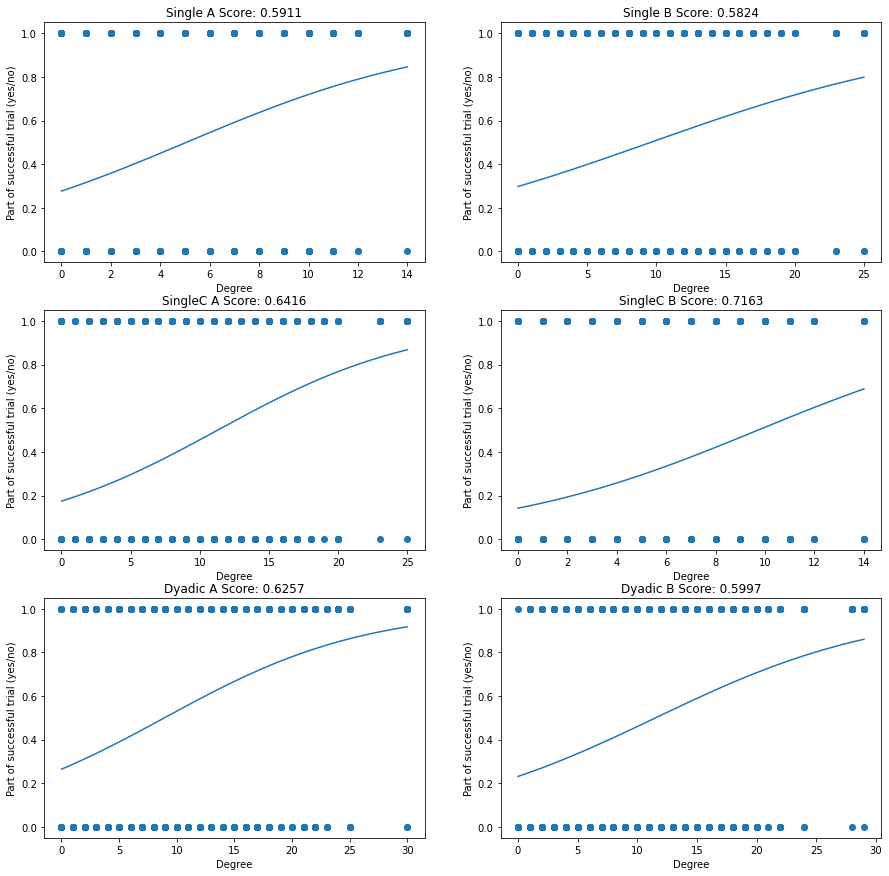

In [95]:
mean_house_degree = centrality_df.copy()
mean_house_degree = mean_house_degree.drop(['Subject','Mean','STD'], axis=1)

building_partof = pd.DataFrame(columns=['Building'])
building_partof['Building'] = mean_house_degree.columns



fig = plt.figure(figsize=(15,15))

conditions=['Single', 'SingleC', 'Dyadic']
directions=['A', 'B']
    
#fig.suptitle(fig_title)

plt_idx = 1

grand_dataset = np.array([])
grand_successes = np.array([])

for condition in conditions:

    PROCESSED_DATA_PATH = './Results/' + condition + '/'
    # open the subject info file of the condition
    with open(PROCESSED_DATA_PATH + condition + '_Performance_Analysis.csv') as f:
        try:
            subject_data = pd.read_csv(f)
        except:
                print("\tCould not load subject info - " + str(condition) + "!")

    for direction in directions:


        # Logistic regression

        con_dir_degree = current_path_str + condition + '_' + direction + '_Degree'
        dataset = []
        dataset = buildings_all_paths_dict[condition][direction]['Degree']
        dataset = np.array(dataset)
        dataset = np.nan_to_num(dataset, copy=True, nan=0.0, posinf=None, neginf=None)
        dataset = dataset.reshape(-1,1)
        dataset = dataset.astype(int)

        con_dir_bool = current_path_str + condition + '_' + direction + '_Bool'
        successes = []
        successes = buildings_all_paths_dict[condition][direction]['Bool']
        successes = np.array(successes)
        successes = successes.reshape(-1,1)
        successes = successes.astype(int)

        grand_dataset = np.append(grand_dataset, dataset)
        grand_successes = np.append(grand_successes, successes)


        clf = LogisticRegression().fit(dataset, successes)
        coef = clf.coef_;
        intercept = clf.intercept_;
        x_in = np.linspace(0, max(dataset), 100);
        y = sigmoid(coef * x_in + intercept)

        plt.subplot(3,2,plt_idx)
        plt.scatter(dataset, successes)
        plt.plot(x_in, y);
        fit_pctg = clf.score(dataset, successes);

        plt.title(condition + ' ' + direction + ' Score: ' + str(round(clf.score(dataset,successes),4)))
        plt.xlabel("Degree")
        plt.ylabel("Part of successful trial (yes/no)")


        plt_idx+=1


    #plt.figure(figsize=(15,5))

    #grand_dataset = grand_dataset.reshape(-1,1)
    #grand_successes = grand_successes.reshape(-1,1)


    #clf = LogisticRegression().fit(grand_dataset, grand_successes)
    #coef = clf.coef_;
    #intercept = clf.intercept_;
    #x_in = np.linspace(0, max(grand_dataset), 100);
    #y = sigmoid(coef * x_in + intercept)

    #plt.scatter(grand_dataset, grand_successes)
    #plt.plot(x_in, y);
    #fit_pctg = clf.score(grand_dataset, grand_successes);
     
        
#if close_figures == True:
    #plt.close('all')